<a href="https://colab.research.google.com/github/singhsneha99/Mapper_Reducer/blob/main/Citibike.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import sys,os
# Block which runs on both Google Colab and Local PC without any modification
if 'google.colab' in sys.modules:    
    project_path = "/content/drive/My Drive/"
    # Google Colab lib
    from google.colab import drive
    # Mount the drive
    drive.mount('/content/drive/', force_remount=True)
    sys.path.append(project_path)
    %cd $project_path

# Let's look at the sys path
print('Current working directory', os.getcwd())

Mounted at /content/drive/
/content/drive/My Drive
Current working directory /content/drive/My Drive


In [3]:
# Load the processed data
data = pd.read_csv('/content/drive/My Drive/TimeSeries_Data/Citibike_time_series.csv')

# Group the data by tract_1000_grp and yr-month
grouped_data = data.groupby(['tract_1000_grp', 'yr-month']).agg({
    'SALE_PRICE': 'mean',
    'counts_per_block': 'sum',
    'tract': 'mean'
}).reset_index()

# Convert the yr-month column to datetime format
grouped_data['yr-month'] = pd.to_datetime(grouped_data['yr-month'])


LINEAR REGRESSION:

<ipython-input-4-0979597e738e>:15: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df['sale_price_pct_change'] = df.groupby('tract_1000_grp')['SALE_PRICE'].apply(lambda x: x.pct_change())


MAE by group:
group
1.0     0.064648
2.0     0.055807
3.0     0.118900
4.0     0.116651
5.0     0.095089
6.0     0.100091
13.0    0.112068
dtype: float64
Overall MAE: 0.0945555255544849


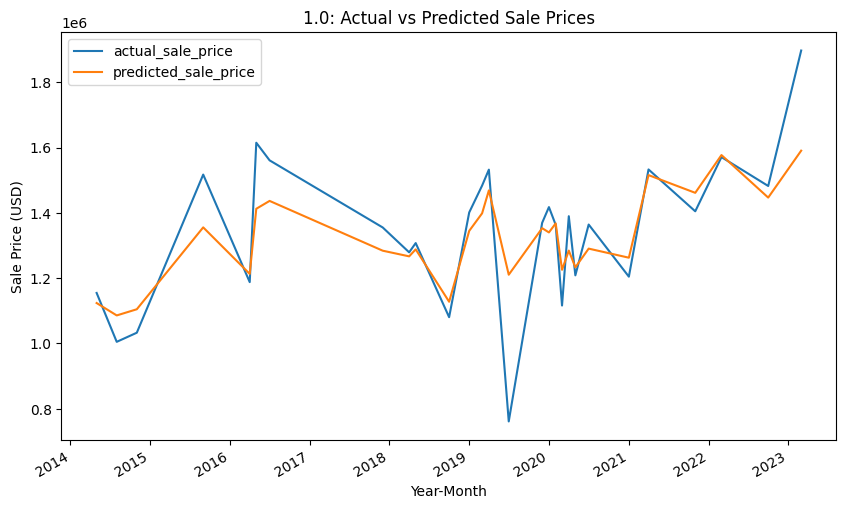

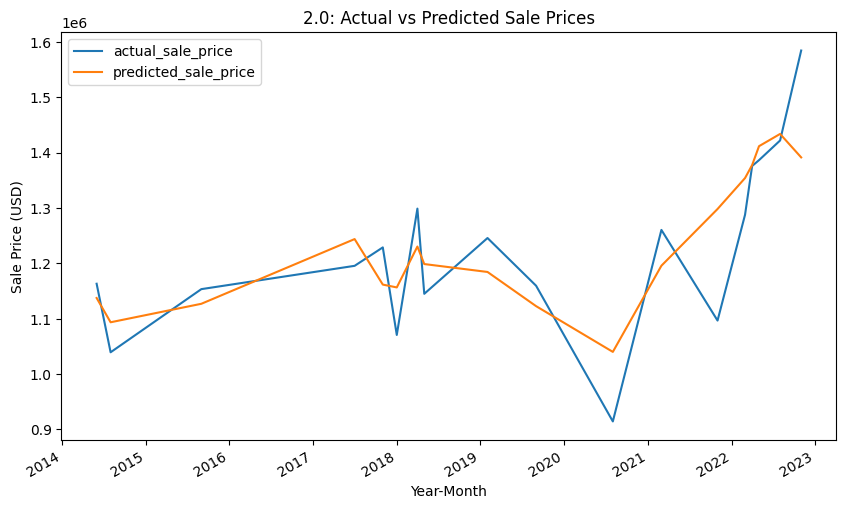

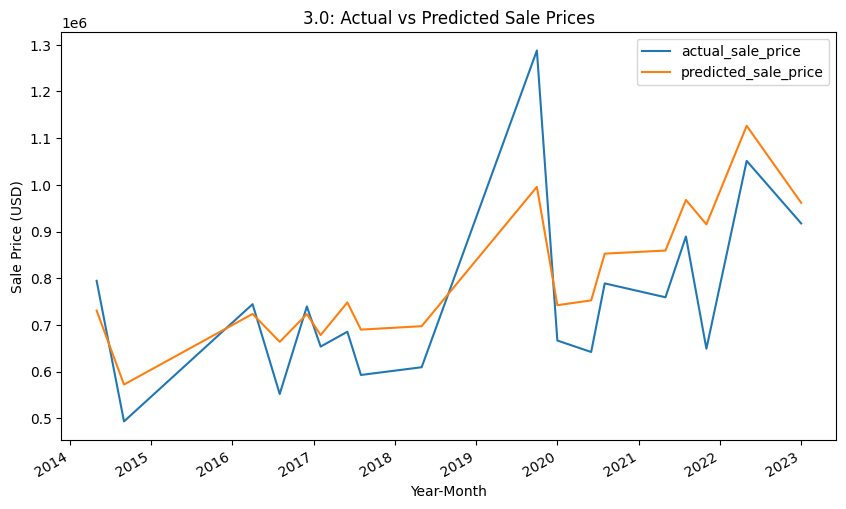

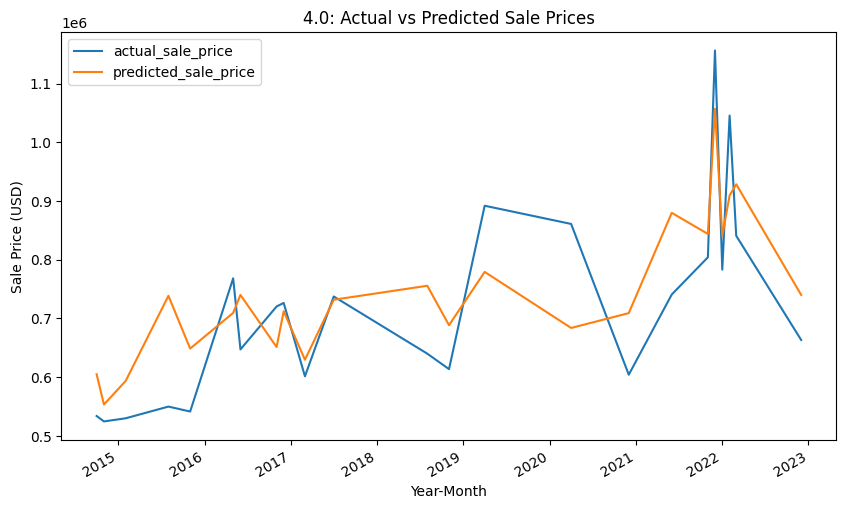

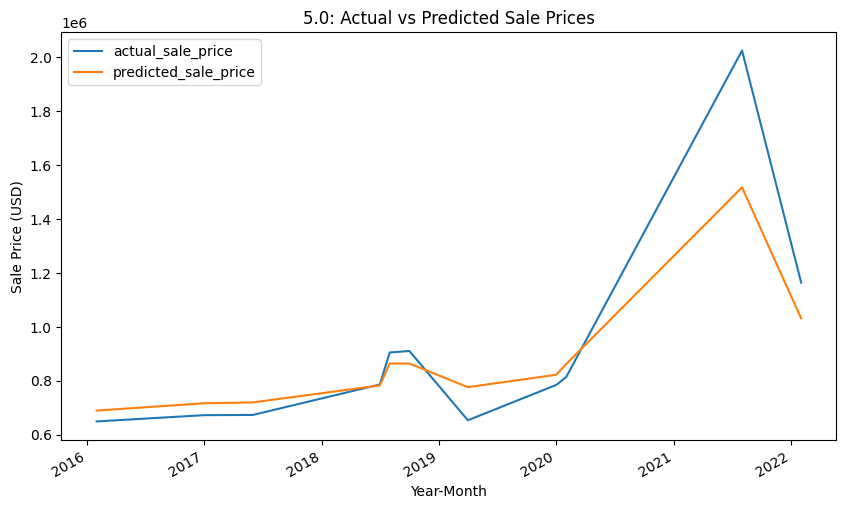

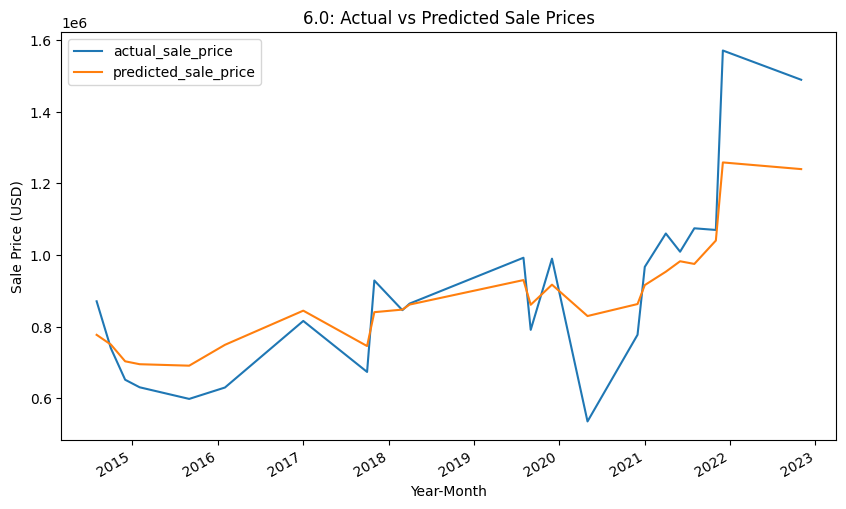

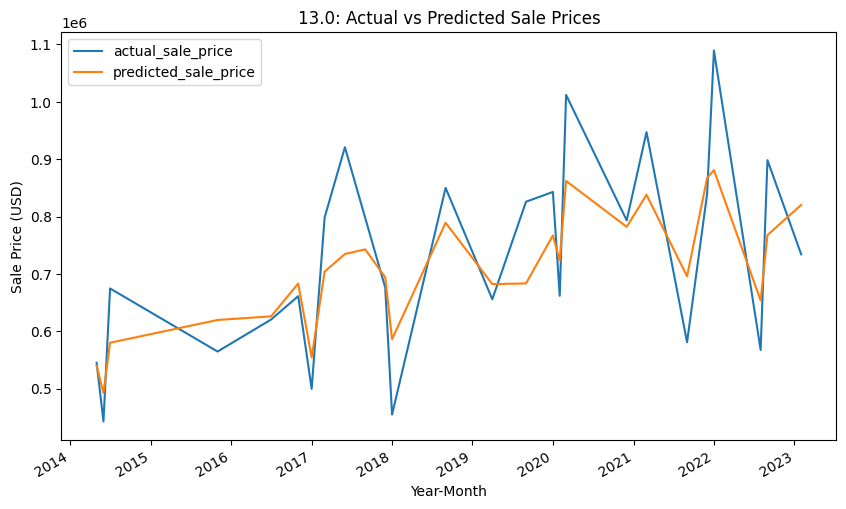

In [4]:
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# Read the data
df = pd.read_csv('/content/drive/My Drive/TimeSeries_Data/Citibike_time_series.csv')

# Convert yr-month to a datetime object
df['yr-month'] = pd.to_datetime(df['yr-month'], format='%Y-%m')

# Calculate the percentage change in SALE_PRICE from the previous month
df['sale_price_pct_change'] = df.groupby('tract_1000_grp')['SALE_PRICE'].apply(lambda x: x.pct_change())

# Split the data into train and test sets
train, test = train_test_split(df, test_size=0.2, random_state=42)

# Drop any rows with missing values
train = train.dropna()
test = test.dropna()

# Fit linear regression model on the train set for each group
models = {}
for group, data in train.groupby('tract_1000_grp'):
    model = LinearRegression()
    X_train = data.drop(['tract_1000_grp', 'yr-month', 'SALE_PRICE', 'sale_price_pct_change'], axis=1)
    y_train = data['sale_price_pct_change']
    model.fit(X_train, y_train)
    models[group] = model

# Make predictions on the test set for each group
predictions = pd.DataFrame(columns=['group', 'yr-month', 'predicted_sale_price_pct_change', 'actual_sale_price_pct_change'])
for group, data in test.groupby('tract_1000_grp'):
    model = models[group]
    X_test = data.drop(['tract_1000_grp', 'yr-month', 'SALE_PRICE', 'sale_price_pct_change'], axis=1)
    y_test_pred = model.predict(X_test)
    data['predicted_sale_price_pct_change'] = y_test_pred
    data['actual_sale_price_pct_change'] = data['sale_price_pct_change']
    data['group'] = group
    predictions = pd.concat([predictions, data[['group', 'yr-month','SALE_PRICE', 'predicted_sale_price_pct_change', 'actual_sale_price_pct_change']]])
    
# Calculate the mean absolute error (MAE) of the predictions for each group
mae_by_group = predictions.groupby('group').apply(lambda x: abs(x['predicted_sale_price_pct_change'] - x['actual_sale_price_pct_change']).mean())

# Calculate the overall mean absolute error (MAE)
overall_mae = abs(predictions['predicted_sale_price_pct_change'] - predictions['actual_sale_price_pct_change']).mean()

# Print the performance metrics for each group and the overall MAE
print("MAE by group:")
print(mae_by_group)
print("Overall MAE:", overall_mae)

#print(predictions.head())
# Plot the predicted and actual sale prices for each group
for group, predictions in predictions.groupby('group', group_keys=False):
    predictions = predictions.set_index('yr-month')
    predictions['predicted_sale_price'] = predictions['SALE_PRICE'] * (1 + predictions['predicted_sale_price_pct_change'])
    predictions['actual_sale_price'] = predictions['SALE_PRICE'] * (1 + predictions['actual_sale_price_pct_change'])
    predictions[['actual_sale_price', 'predicted_sale_price']].plot(figsize=(10, 6))
    plt.title(f'{group}: Actual vs Predicted Sale Prices')
    plt.xlabel('Year-Month')
    plt.ylabel('Sale Price (USD)')
    plt.show()



LSTM:

In [60]:
from keras.preprocessing.sequence import TimeseriesGenerator

# Define the number of time steps and the batch size
n_input = 12
batch_size = 32

# Define the generator for the train set
train_gen = TimeseriesGenerator(train['sale_price_pct_change'].values,
                                train['sale_price_pct_change'].values,
                                length=n_input, batch_size=batch_size)

# Define the generator for the test set
test_gen = TimeseriesGenerator(test['sale_price_pct_change'].values,
                               test['sale_price_pct_change'].values,
                               length=n_input, batch_size=batch_size)


ARIMA:

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# Read the data
df = pd.read_csv('/content/drive/My Drive/TimeSeries_Data/Citibike_time_series.csv')

# Convert yr-month to a datetime object
df['yr-month'] = pd.to_datetime(df['yr-month'], format='%Y-%m')

# Calculate the percentage change in SALE_PRICE from the previous month
df['sale_price_pct_change'] = df.groupby('tract_1000_grp')['SALE_PRICE'].apply(lambda x: x.pct_change())

# Split the data into train and test sets
train, test = train_test_split(df, test_size=0.2, random_state=42)

# Drop any rows with missing values
train = train.dropna()
test = test.dropna()


train.head()


<ipython-input-34-bacb10a6e48c>:15: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df['sale_price_pct_change'] = df.groupby('tract_1000_grp')['SALE_PRICE'].apply(lambda x: x.pct_change())


,yr-month,tract_1000_grp,SALE_PRICE,counts_per_block,tract,sale_price_pct_change
586,2018-05-01,6.0,9.112658e+05,262,88624.0,0.071436
131,2015-07-01,2.0,1.165923e+06,1239,212556.0,-0.045635
44,2017-06-01,1.0,1.459812e+06,1029,1049951.0,0.084263
70,2019-08-01,1.0,1.293418e+06,836,1352598.0,0.061305
581,2018-11-01,6.0,7.576553e+05,263,58878.0,-0.096825


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAE by group:
group
1.0     0.074883
2.0     0.060346
3.0     0.335611
4.0     0.108071
5.0     0.108407
6.0     0.091356
13.0    0.112781
dtype: float64
Overall MAE: 0.12201069409900848


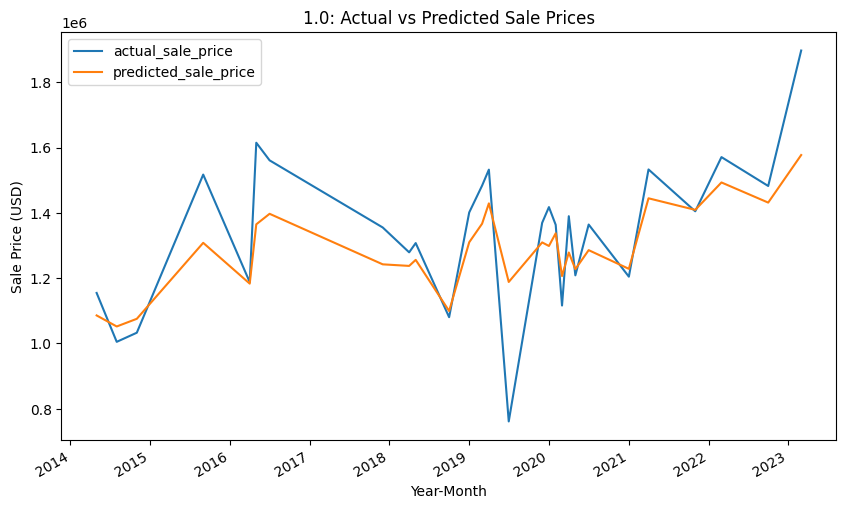

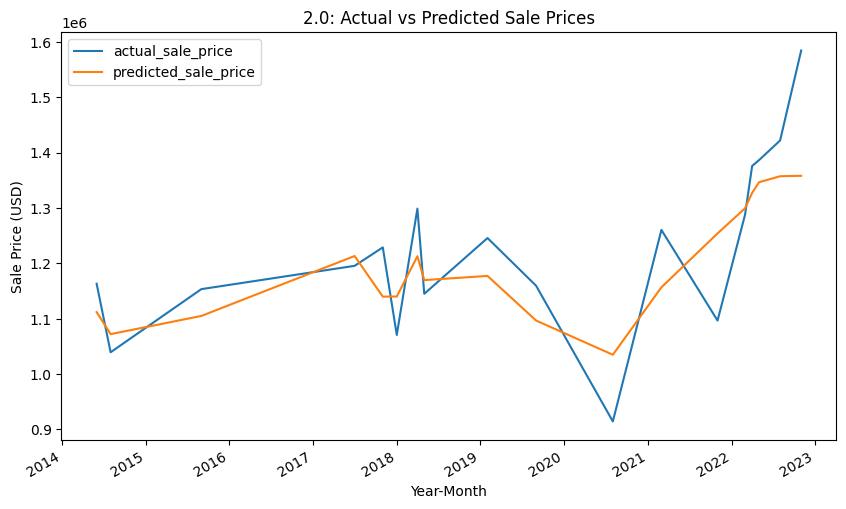

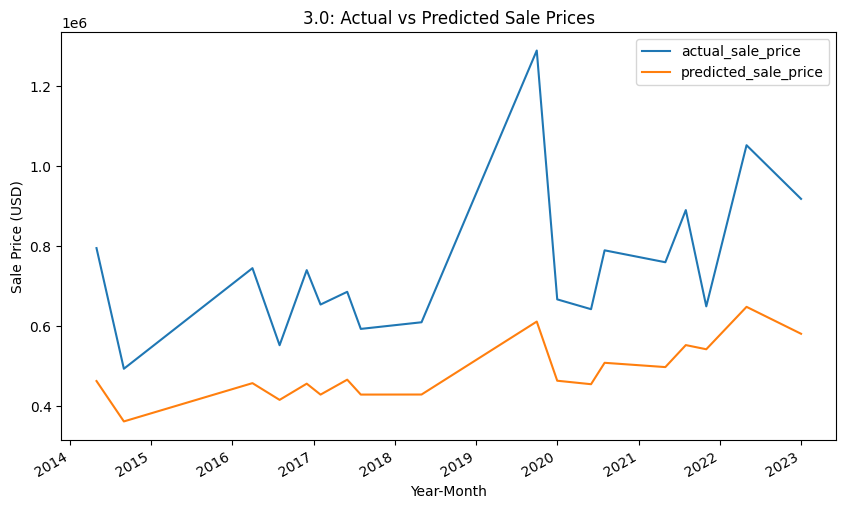

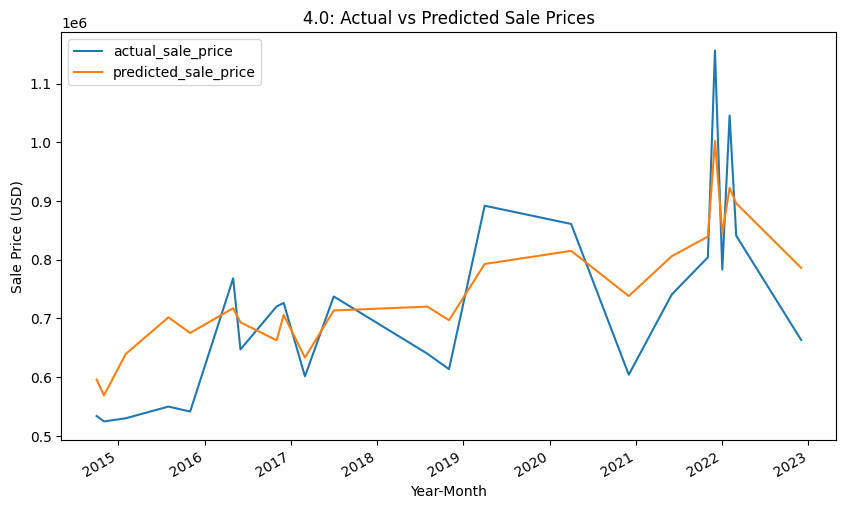

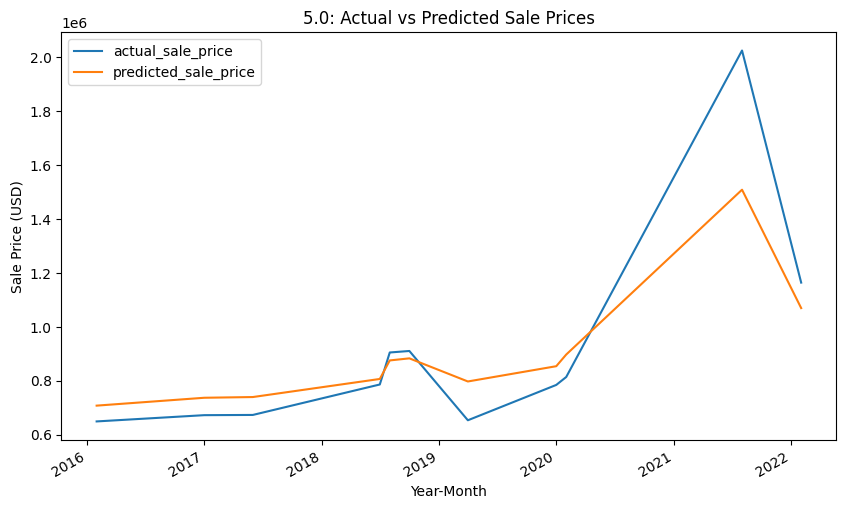

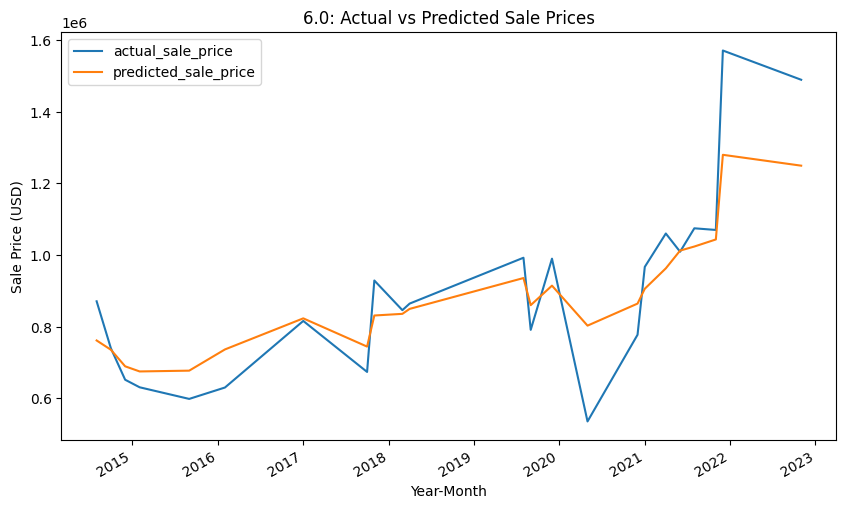

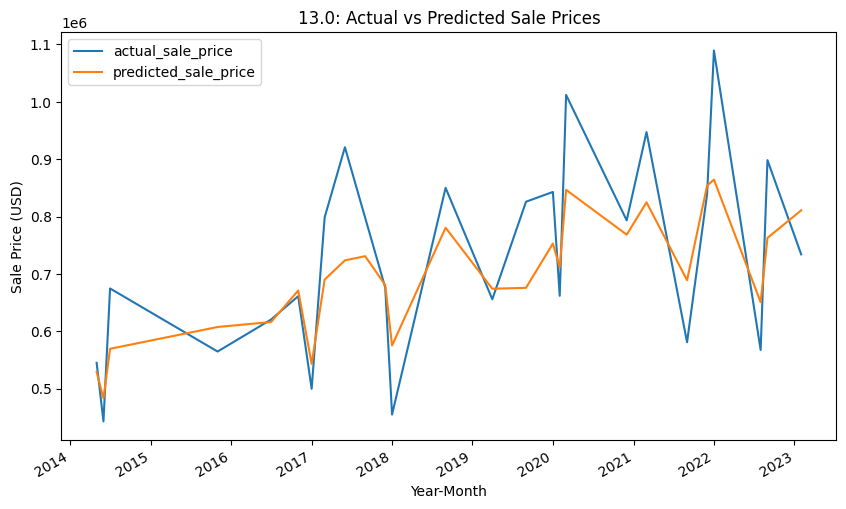

In [38]:
# Fit ARIMA model on the train set for each group
models = {}
for group, df in train.groupby('tract_1000_grp'):
    df = df.set_index('yr-month')
    # set frequency to Month Start (MS)
    df = df.asfreq('MS')
    model = ARIMA(df['sale_price_pct_change'], order=(1, 0, 0), freq=df.index.freq)  # pass frequency to ARIMA model
    model_fit = model.fit()
    models[group] = model_fit

# Make predictions on the test set for each group
predictions = pd.DataFrame(columns=['group', 'yr-month', 'predicted_sale_price_pct_change', 'actual_sale_price_pct_change'])
for group, data in test.groupby('tract_1000_grp'):
    model_fit = models[group]
    start_index = len(data)  # set the start index to the end of the training data
    end_index = start_index + len(data) - 1  # set the end index to the end of the test data
    y_test_pred, *_ = model_fit.forecast(steps=len(data)) # forecast future values
    data['predicted_sale_price_pct_change'] = y_test_pred
    data['actual_sale_price_pct_change'] = data['sale_price_pct_change']
    data['group'] = group
    predictions = pd.concat([predictions, data[['group', 'yr-month','SALE_PRICE', 'predicted_sale_price_pct_change', 'actual_sale_price_pct_change']]])

# Calculate the mean absolute error (MAE) of the predictions for each group
mae_by_group = predictions.groupby('group').apply(lambda x: abs(x['predicted_sale_price_pct_change'] - x['actual_sale_price_pct_change']).mean())

# Calculate the overall mean absolute error (MAE)
overall_mae = abs(predictions['predicted_sale_price_pct_change'] - predictions['actual_sale_price_pct_change']).mean()

# Print the performance metrics for each group and the overall MAE
print("MAE by group:")
print(mae_by_group)
print("Overall MAE:", overall_mae)

# Plot the predicted and actual sale prices for each group
for group, predictions in predictions.groupby('group', group_keys=False):
    predictions = predictions.set_index('yr-month')
    predictions['predicted_sale_price'] = predictions['SALE_PRICE'] * (1 + predictions['predicted_sale_price_pct_change'])
    predictions['actual_sale_price'] = predictions['SALE_PRICE'] * (1 + predictions['actual_sale_price_pct_change'])
    predictions[['actual_sale_price', 'predicted_sale_price']].plot(figsize=(10, 6))
    plt.title(f'{group}: Actual vs Predicted Sale Prices')
    plt.xlabel('Year-Month')
    plt.ylabel('Sale Price (USD)')
    plt.show()